# **00. Assumptionss**

1. CTR is 1 for all advertisers
2. Stochastic Bidders: my competitors sample their bids from random uniform distributions
3. Competitors are free to exceed my budget

# **01. Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from IPython.display import clear_output

# **02. Enviroment set-up**

## *02.01. Thruthful (second price) auctions*

In [3]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [4]:
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):       #ctrs: Click to rate; advertiser's click probability
        self.ctrs = ctrs 
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids     # adv: advertiser
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

### Clairvoyant agent

In [5]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0       # Cumulative cost 
    i = 0
    while c <= B-1 and i < n_users:         # ++ Here we are assuming that the maximum bid is 1
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    clairvoyant_bids = clairvoyant_bids*m_t
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

## *02.02. Pricing enviroment*

In [6]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t): # p_t is price, n_t is the number of people who see the product. t is the round
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t # r_t: profit
        return d_t, r_t

In this case the prices have to be in the range [0, 1] because of the project requirements, so no re-scaling is needed

# **03. Agents set-up**

## *03.01. Auction: Multiplicative pacing agent*

In [7]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

## *03.02. Auction: UCB-like agent*

In [8]:
class UCBBidingAgent:
    def __init__(self, valuation, budget, T, available_bids, scale=1):
        self.available_bids = available_bids
        self.discretization = available_bids.size
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.t = 0
        self.rho = self.budget/self.T
        self.avg_ft = np.zeros(self.discretization)
        self.avg_ft_UCB = np.zeros(self.discretization)
        self.avg_ct = np.zeros(self.discretization)
        self.avg_ct_LCB = np.zeros(self.discretization)
        self.gamma = np.full(self.discretization, 1/self.discretization)
        self.N = np.zeros(self.discretization)
        self.bid_t = None
        self.scale = scale
    
    def optimization_correction(self):
        gamma_equal_1_index = np.where(self.res.x == 1)       # Look where is that "1" value
        a = self.avg_ft_UCB
        b = self.avg_ct_LCB
        bool_vector = np.logical_and(a == self.avg_ft_UCB[gamma_equal_1_index], 
                                     b == self.avg_ct_LCB[gamma_equal_1_index])  # Compare if there is other bid with the same characteristics
        self.res.x = np.where(bool_vector, 1/np.sum(bool_vector), 0)             # Share the probabilities with the bids that have the same characteristics
    
    def optimization(self):
        self.c = -self.avg_ft_UCB*self.gamma
        self.A_ub = [self.gamma*self.avg_ct_LCB]
        self.b_ub = [self.rho]
        self.A_eq = [np.ones(self.discretization)]
        self.b_eq = [1]
        self.res = optimize.linprog(self.c, A_ub=self.A_ub, b_ub=self.b_ub, A_eq=self.A_eq, b_eq=self.b_eq, bounds=(0,1))
        if np.any(self.res.x == 1):       # If there is a closed answer like [1,0,0,0], look if there is another possible optimal solution
            self.optimization_correction()
        return self.res.x
    
    def bid(self):
        if self.budget < 1:
            return 0
        
        if self.t < self.discretization:
            self.bid_t_index = self.t
        else:
            self.gamma = self.optimization()
            self.bid_t_index = np.random.choice(range(self.discretization), p= self.gamma)
            
        self.bid_t = self.available_bids[self.bid_t_index]
        return self.bid_t
    
    def update(self, f_t, c_t):
        self.N[self.bid_t_index] += 1
        self.avg_ft[self.bid_t_index] += (f_t - self.avg_ft[self.bid_t_index])/self.N[self.bid_t_index]
        self.avg_ft_UCB[self.bid_t_index] = self.avg_ft[self.bid_t_index] + self.scale*np.sqrt((2*np.log(self.T))/self.N[self.bid_t_index])
        # print(self.avg_ft_UCB)
        self.avg_ct[self.bid_t_index] += (c_t - self.avg_ct[self.bid_t_index])/self.N[self.bid_t_index]
        self.avg_ct_LCB[self.bid_t_index] = self.avg_ct[self.bid_t_index] - self.scale*np.sqrt((2*np.log(self.T))/self.N[self.bid_t_index])
        # print(self.avg_ct_LCB)
        self.budget -= c_t
        self.t += 1

## *03.03. Pricing agent*

### 03.03.01. RBF Gaussian Processes

In [9]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

### 03.03.02. GP-UCB Agent setting

In [10]:
scale_parameter = 2
B_parameter = 1

class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale= scale_parameter).fit()  
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: B_parameter + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))      
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

# **04. Simulation**

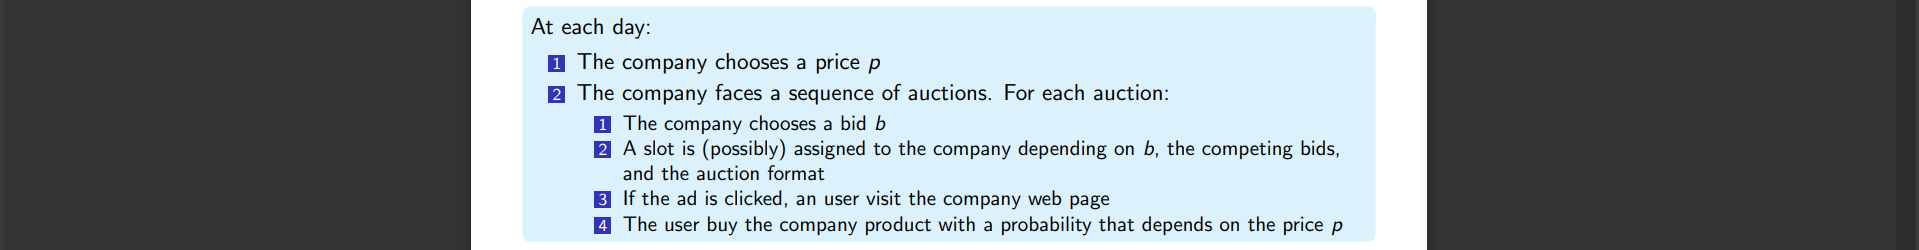

## *04.01. Parameters*

### 04.01.01. Auction parameters

In [11]:
# Advertisers' fixed parameters
## we assume that our agent has the FIRST index
n_advertisers = 4           # including myself
my_valuation = 0.1
B = 200
available_bids = np.linspace(0,0.1,60)
ctrs = np.ones(n_advertisers)   # All ctrs are 1
scale_for_UCB_Bidding = 10

# Environmental settings
n_users = 10000     # in total (the whole simulation of all the days)

# Competitors
other_bids = np.random.uniform(0, 0.11, size = (n_advertisers - 1, n_users))
m_t = other_bids.max(axis=0)


# Clairvoyant bids
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

### 04.01.02. Pricing parameters and initialization

In [12]:
T = 100         # Number of days
cost = 0.03     # Cost of the product/service



K = 100

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/1
reward_function = lambda price, n_sales: (price-cost)*n_sales

min_price, max_price = 0, 1
prices = np.linspace(min_price, max_price, K)


def get_clairvoyant_reward_per_day(n_customers, prices = prices, conversion_probability = conversion_probability):
    profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
    best_price_index = np.argmax(profit_curve)
    # best_price = prices[best_price_index]
    expected_clairvoyant_rewards = np.array([]) # empty at beginning
    return np.array([profit_curve[best_price_index]])

## *04.02. Only one instance of the simulation*

### 04.02.01 Multiplicative pacing agent

Assumption:

- 200 users per day
- 60 days

In [13]:
auction = SecondPriceAuction(ctrs)
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                budget=B,
                                T=n_users, 
                                eta=eta)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
wins_per_day = np.zeros(T)

pricing_agent = GPUCBAgent(T, discretization=K)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

pricing_agent_rewards = np.array([])
expected_pricing_clairvoyant_rewards = np.array([])


for d in range(T):
    p_t = pricing_agent.pull_arm()                  # Choose the price for the day t
    # p_t = rescale(p_t, min_price, max_price)      # ++ In this case is not needed as prices are already in the range [0, 1]
    
    # Auctions
    for u in range(int(n_users/T)):
        v = int(n_users/T)*d + u
        clear_output(wait=False)
        print(100*v/n_users, "%")
        # interaction
        my_bid = agent.bid()
        # print(other_bids[:, u].ravel())
        bids = np.append(my_bid, other_bids[:, v].ravel())
        # print(bids)
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[v])*my_win, m_t[v]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        wins_per_day[d] += my_win
    
    
    
    n_customers = wins_per_day[d]
    
    d_t, r_t = env.round(p_t, n_customers)
    pricing_agent.update(r_t/n_customers)
    pricing_agent_rewards = np.append(pricing_agent_rewards, r_t)
    expected_pricing_clairvoyant_rewards = np.concatenate([expected_pricing_clairvoyant_rewards, 
                                                   get_clairvoyant_reward_per_day(n_customers, prices, conversion_probability)])
    

cumulative_regret_pricing = np.cumsum(expected_pricing_clairvoyant_rewards - pricing_agent_rewards)
average_regret_pricing = cumulative_regret_pricing/np.arange(1, len(cumulative_regret_pricing)+1)
cumulative_regret_auctions = np.cumsum(clairvoyant_utilities - utilities)

99.99 %


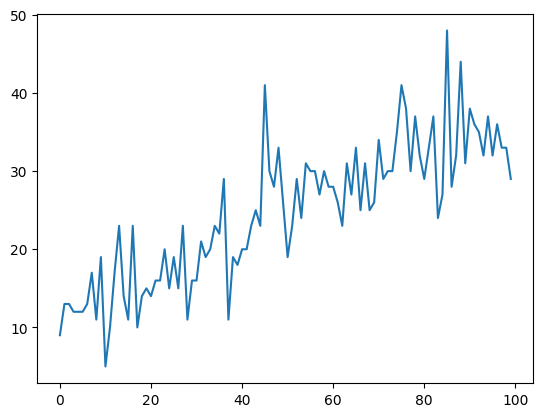

In [14]:
plt.plot(wins_per_day)

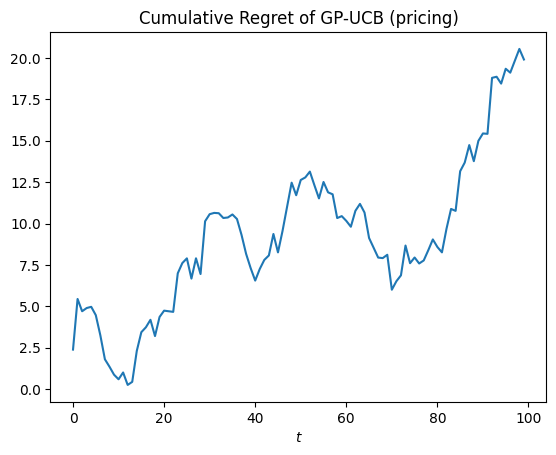

In [15]:
plt.figure()
plt.plot(cumulative_regret_pricing)
plt.title('Cumulative Regret of GP-UCB (pricing)')
plt.xlabel('$t$')
plt.show();

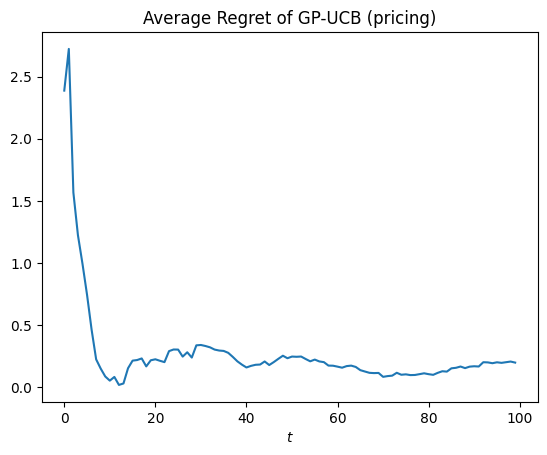

In [16]:
plt.figure()
plt.plot(average_regret_pricing)
plt.title('Average Regret of GP-UCB (pricing)')
plt.xlabel('$t$')
plt.show();

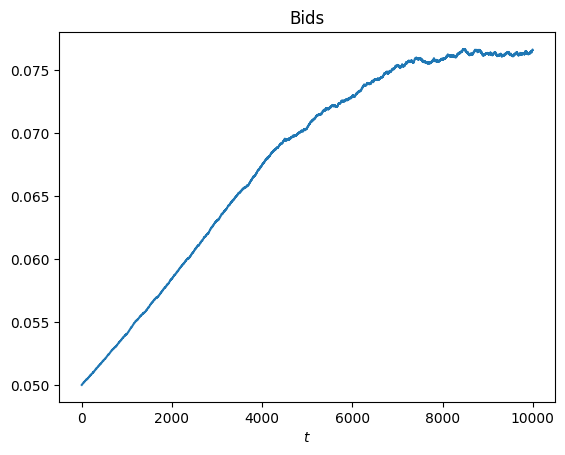

In [17]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.title('Bids')
plt.show()

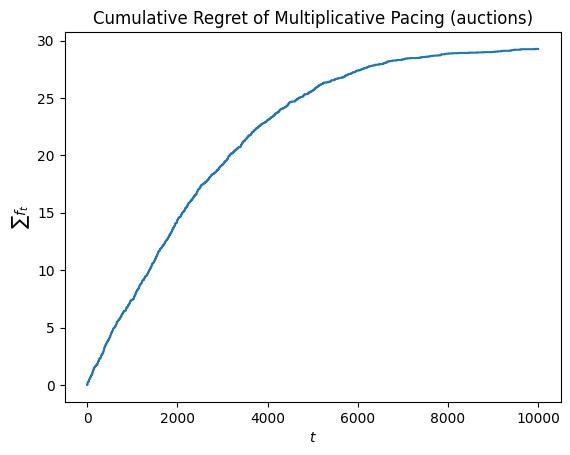

In [18]:

plt.plot(cumulative_regret_auctions)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing (auctions)')
plt.show()

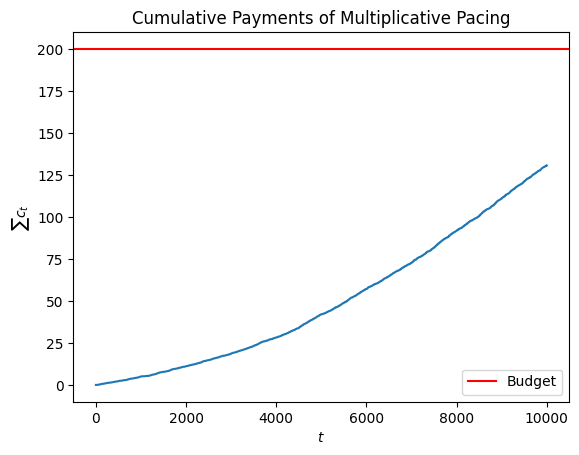

In [19]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

### 04.02.02 UCB-Biding agent

In [20]:
from IPython.display import clear_output

auction = SecondPriceAuction(ctrs)
eta = 1/np.sqrt(n_users) # from theory
agent = UCBBidingAgent(valuation=my_valuation,
                                budget=B,
                                T=n_users, 
                                available_bids= available_bids,
                                scale= scale_for_UCB_Bidding)

pricing_agent = GPUCBAgent(T, discretization=K)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
        
utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
wins_per_day = np.zeros(T)


pricing_agent_rewards = np.array([])
expected_pricing_clairvoyant_rewards = np.array([])


for d in range(T):
    p_t = pricing_agent.pull_arm()                  # Choose the price for the day t
    # p_t = rescale(p_t, min_price, max_price)      # ++ In this case is not needed as prices are already in the range [0, 1]
    
    # Auctions
    for u in range(int(n_users/T)):
        v = int(n_users/T)*d + u
        clear_output(wait=False)
        print(100*v/n_users, "%")
        # interaction
        my_bid = agent.bid()
        # print(other_bids[:, u].ravel())
        bids = np.append(my_bid, other_bids[:, v].ravel())
        # print(bids)
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[v])*my_win, m_t[v]*my_win
        agent.update(f_t, c_t)
        # logging
        utilities = np.append(utilities, f_t)
        my_bids = np.append(my_bids, my_bid)
        my_payments = np.append(my_payments, c_t)
        wins_per_day[d] += my_win
    
    
    
    n_customers = wins_per_day[d]
    
    d_t, r_t = env.round(p_t, n_customers)
    pricing_agent.update(r_t/n_customers)
    pricing_agent_rewards = np.append(pricing_agent_rewards, r_t)
    expected_pricing_clairvoyant_rewards = np.concatenate([expected_pricing_clairvoyant_rewards, 
                                                   get_clairvoyant_reward_per_day(n_customers, prices, conversion_probability)])
    

cumulative_regret_pricing = np.cumsum(expected_pricing_clairvoyant_rewards - pricing_agent_rewards)
cumulative_regret_auctions = np.cumsum(clairvoyant_utilities - utilities)

99.99 %


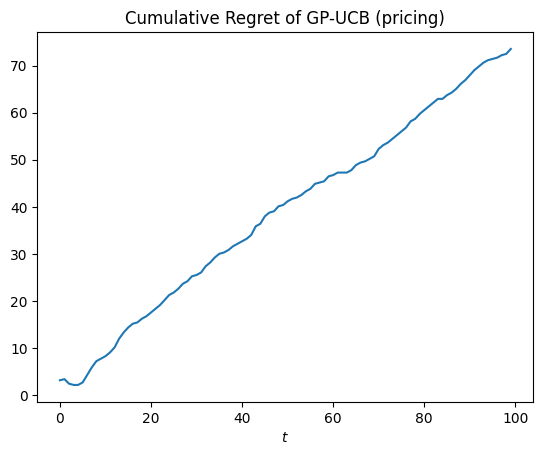

In [21]:
plt.figure()
plt.plot(cumulative_regret_pricing)
plt.title('Cumulative Regret of GP-UCB (pricing)')
plt.xlabel('$t$')
plt.show();

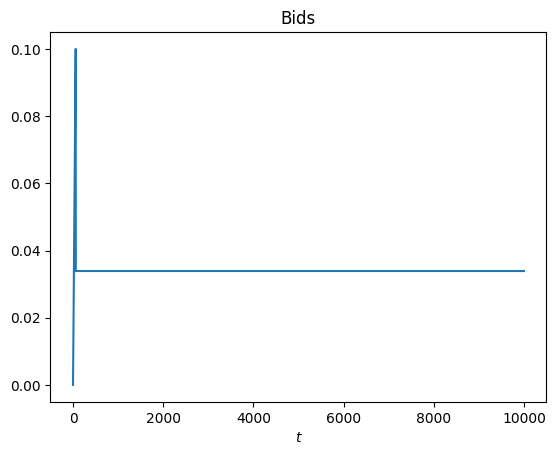

In [22]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.title('Bids')
plt.show()

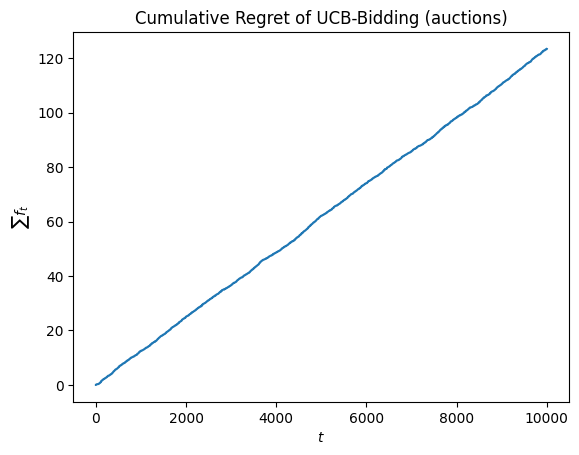

In [23]:
plt.plot(cumulative_regret_auctions)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of UCB-Bidding (auctions)')
plt.show()

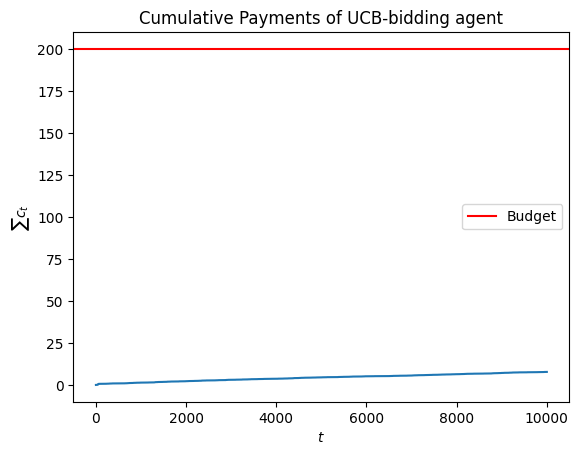

In [24]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB-bidding agent')
plt.show()

## *04.03. Multiple instances of the simulation*

### 04.03.01 Multiplicative pacing agent

In [25]:
n_epochs = 5
all_regrets_mpa = []
all_payments_mpa = []
all_bids_mpa = []
all_regrets_pri1 = []


for i in range(n_epochs):
    auction = SecondPriceAuction(ctrs)
    eta = 1/np.sqrt(n_users) # from theory
    agent = MultiplicativePacingAgent(valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    wins_per_day = np.zeros(T)
    
    pricing_agent = GPUCBAgent(T, discretization=K)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    
    cumulative_regret_pricing = None
    cumulative_regret_auctions = None
    average_regret_pricing  = None

    pricing_agent_rewards = np.array([])
    expected_pricing_clairvoyant_rewards = np.array([])

    np.random.seed(i)
    
    
    for d in range(T):
        p_t = pricing_agent.pull_arm()                  # Choose the price for the day t
        # p_t = rescale(p_t, min_price, max_price)      # ++ In this case is not needed as prices are already in the range [0, 1]
        
        # Auctions
        for u in range(int(n_users/T)):
            v = int(n_users/T)*d + u
            clear_output(wait=False)
            print(100*v/n_users, "%, ", i)
            # interaction
            my_bid = agent.bid()
            # print(other_bids[:, u].ravel())
            bids = np.append(my_bid, other_bids[:, v].ravel())
            # print(bids)
            winners, payments_per_click = auction.round(bids=bids)
            my_win = int(winners==0)
            f_t, c_t = (my_valuation-m_t[v])*my_win, m_t[v]*my_win
            agent.update(f_t, c_t)
            # logging
            utilities = np.append(utilities, f_t)
            my_bids = np.append(my_bids, my_bid)
            my_payments = np.append(my_payments, c_t)
            wins_per_day[d] += my_win
        
        
        
        n_customers = wins_per_day[d]
        
        d_t, r_t = env.round(p_t, n_customers)
        pricing_agent.update(r_t/n_customers)
        pricing_agent_rewards = np.append(pricing_agent_rewards, r_t)
        expected_pricing_clairvoyant_rewards = np.concatenate([expected_pricing_clairvoyant_rewards, 
                                                    get_clairvoyant_reward_per_day(n_customers, prices, conversion_probability)])
        

    cumulative_regret_pricing = np.cumsum(expected_pricing_clairvoyant_rewards - pricing_agent_rewards)
    average_regret_pricing = cumulative_regret_pricing/np.arange(1, len(cumulative_regret_pricing)+1)
    cumulative_regret_auctions = np.cumsum(clairvoyant_utilities - utilities)
    cumulative_payments = np.cumsum(my_payments)
    
    all_regrets_pri1.append(cumulative_regret_pricing)
    all_regrets_mpa.append(cumulative_regret_auctions)
    all_payments_mpa.append(cumulative_payments)
    all_bids_mpa.append(my_bids)

    
avg_regret_mpa = np.array(all_regrets_mpa).mean(axis=0)
std_regret_mpa = np.array(all_regrets_mpa).std(axis=0)

avg_regret_pri1 = np.array(all_regrets_pri1).mean(axis=0)
std_regret_pri1 = np.array(all_regrets_pri1).std(axis=0)

avg_payments_mpa = np.array(all_payments_mpa).mean(axis=0)
std_payments_mpa = np.array(all_payments_mpa).std(axis=0)

avg_bids_mpa = np.array(all_bids_mpa).mean(axis=0)
std_bids_mpa = np.array(all_bids_mpa).std(axis=0)
    


99.99 %,  4


### 04.03.02 UCB-bidding agent

In [26]:
n_epochs = n_epochs
all_regrets_ucb = []
all_payments_ucb = []
all_bids_ucb = []
all_regrets_pri2 = []


for i in range(n_epochs):
    auction = SecondPriceAuction(ctrs)
    # eta = 1/np.sqrt(n_users) # from theory
    agent = UCBBidingAgent(valuation=my_valuation,
                                budget=B,
                                T=n_users, 
                                available_bids= available_bids,
                                scale= scale_for_UCB_Bidding)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    wins_per_day = np.zeros(T)
    
    pricing_agent = GPUCBAgent(T, discretization=K)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    
    cumulative_regret_pricing = None
    cumulative_regret_auctions = None
    average_regret_pricing  = None

    pricing_agent_rewards = np.array([])
    expected_pricing_clairvoyant_rewards = np.array([])

    np.random.seed(i)
    
    
    for d in range(T):
        p_t = pricing_agent.pull_arm()                  # Choose the price for the day t
        # p_t = rescale(p_t, min_price, max_price)      # ++ In this case is not needed as prices are already in the range [0, 1]
        
        # Auctions
        for u in range(int(n_users/T)):
            v = int(n_users/T)*d + u
            clear_output(wait=False)
            print(100*v/n_users, "%, ", i)
            # interaction
            my_bid = agent.bid()
            # print(other_bids[:, u].ravel())
            bids = np.append(my_bid, other_bids[:, v].ravel())
            # print(bids)
            winners, payments_per_click = auction.round(bids=bids)
            my_win = int(winners==0)
            f_t, c_t = (my_valuation-m_t[v])*my_win, m_t[v]*my_win
            agent.update(f_t, c_t)
            # logging
            utilities = np.append(utilities, f_t)
            my_bids = np.append(my_bids, my_bid)
            my_payments = np.append(my_payments, c_t)
            wins_per_day[d] += my_win
        
        
        
        n_customers = wins_per_day[d]
        
        d_t, r_t = env.round(p_t, n_customers)
        pricing_agent.update(r_t/n_customers)
        pricing_agent_rewards = np.append(pricing_agent_rewards, r_t)
        expected_pricing_clairvoyant_rewards = np.concatenate([expected_pricing_clairvoyant_rewards, 
                                                    get_clairvoyant_reward_per_day(n_customers, prices, conversion_probability)])
        

    cumulative_regret_pricing = np.cumsum(expected_pricing_clairvoyant_rewards - pricing_agent_rewards)
    average_regret_pricing = cumulative_regret_pricing/np.arange(1, len(cumulative_regret_pricing)+1)
    cumulative_regret_auctions = np.cumsum(clairvoyant_utilities - utilities)
    cumulative_payments = np.cumsum(my_payments)
    
    all_regrets_pri2.append(cumulative_regret_pricing)
    all_regrets_ucb.append(cumulative_regret_auctions)
    all_payments_ucb.append(cumulative_payments)
    all_bids_ucb.append(my_bids)

    
avg_regret_ucb = np.array(all_regrets_ucb).mean(axis=0)
std_regret_ucb = np.array(all_regrets_ucb).std(axis=0)

avg_regret_pri2 = np.array(all_regrets_pri2).mean(axis=0)
std_regret_pri2 = np.array(all_regrets_pri2).std(axis=0)

avg_payments_ucb = np.array(all_payments_ucb).mean(axis=0)
std_payments_ucb = np.array(all_payments_ucb).std(axis=0)

avg_bids_ucb = np.array(all_bids_ucb).mean(axis=0)
std_bids_ucb = np.array(all_bids_ucb).std(axis=0)
    


99.99 %,  4


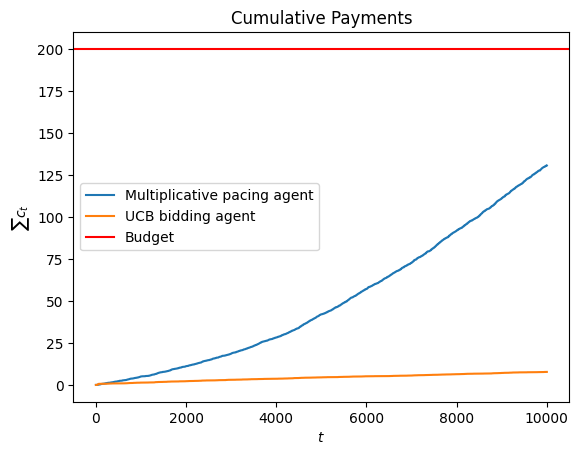

In [27]:
plt.plot(np.arange(n_users), avg_payments_mpa, label="Multiplicative pacing agent")
plt.plot(np.arange(n_users), avg_payments_ucb, label="UCB bidding agent")
plt.fill_between(np.arange(n_users), avg_payments_mpa-std_payments_mpa, avg_payments_mpa+std_payments_mpa, alpha=0.3)
plt.fill_between(np.arange(n_users), avg_payments_ucb-std_payments_ucb, avg_payments_ucb+std_payments_ucb, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments')
plt.show()

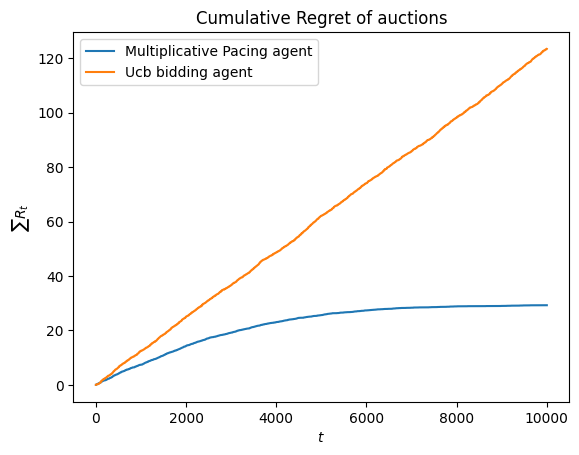

In [28]:
plt.plot(np.arange(n_users), avg_regret_mpa, label="Multiplicative Pacing agent")
plt.plot(np.arange(n_users), avg_regret_ucb, label="Ucb bidding agent")
plt.fill_between(np.arange(n_users), avg_regret_mpa-std_regret_mpa, avg_regret_mpa+std_regret_mpa, alpha=0.3)
plt.fill_between(np.arange(n_users), avg_regret_ucb-std_regret_ucb, avg_regret_ucb+std_regret_ucb, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.legend()
plt.title('Cumulative Regret of auctions')
plt.show()

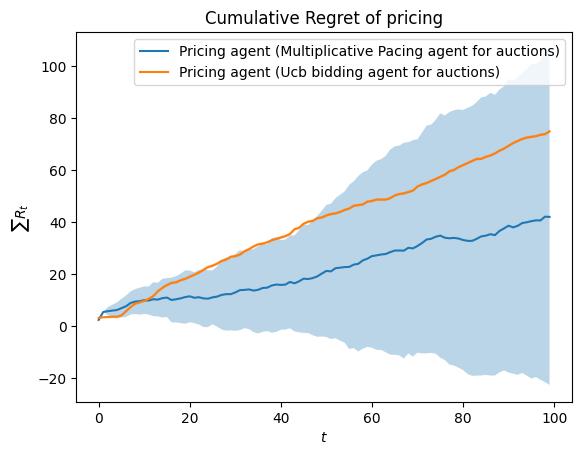

In [29]:
plt.plot(np.arange(T), avg_regret_pri1, label="Pricing agent (Multiplicative Pacing agent for auctions)")
plt.plot(np.arange(T), avg_regret_pri2, label="Pricing agent (Ucb bidding agent for auctions)")
plt.fill_between(np.arange(T), avg_regret_pri1-std_regret_pri1, avg_regret_pri1+std_regret_pri1, alpha=0.3)
plt.fill_between(np.arange(T), avg_regret_pri2-std_regret_pri2, avg_regret_pri2+std_regret_pri2, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.legend()
plt.title('Cumulative Regret of pricing')
plt.show()

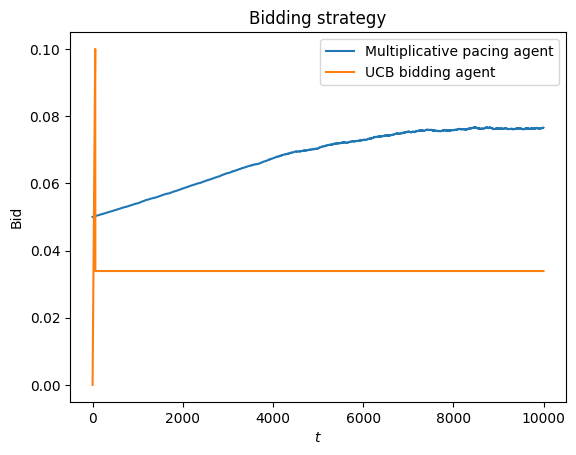

In [30]:
plt.plot(np.arange(n_users), avg_bids_mpa, label="Multiplicative pacing agent")
plt.plot(np.arange(n_users), avg_bids_ucb, label="UCB bidding agent")
plt.fill_between(np.arange(n_users), avg_bids_mpa-std_bids_mpa, avg_bids_mpa+std_bids_mpa, alpha=0.3)
plt.fill_between(np.arange(n_users), avg_bids_ucb-std_bids_ucb, avg_bids_ucb+std_bids_ucb, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('Bid')
plt.legend()
plt.title('Bidding strategy')
plt.show()